In [563]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import datetime as dt
import importlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

from sklearn import metrics
from sklearn import preprocessing as prep

from packages import tools
from packages import models

In [2]:
np.random.seed(1)

# Feedforward Neural Networks (FFNNs)

We will choose a default of three hidden layers with equal number of nodes, and will focus more on varying the number of nodes in each layer.

First, we create the skeleton NN framework (building training set, prepping the NN model) that trains on a given dataset and outputs a day-aheaad forecast.

In [778]:
def create_3L_ffn(num_of_nodes, input_cols, act_fn, opt="adam", loss="mse", metrics="mean_squared_error"):
    model = Sequential()
    initializer = initializers.he_uniform(1)
    
    # Add first hidden layer (with input layer specification)
    model.add(Dense(num_of_nodes, activation=act_fn, input_shape=(input_cols,), kernel_initializer=initializer))
    
    # Add remaining hidden layers
    for _ in range(2):
        model.add(Dense(num_of_nodes, activation=act_fn, kernel_initializer=initializer))

    # Add output layer
    model.add(Dense(1, kernel_initializer=initializer))

#     optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return(model)

The code below for reading in the datasets is exactly the same as for the random forests.

In [779]:
# Read in datasets
price_path = ["Datasets/DAMPrices.csv", "Datasets/DAMPrices2.csv"]
prices = tools.read_price_data(price_path)

bm_price_paths = ["Datasets/BMInfo1.csv", "Datasets/BMInfo2.csv", "Datasets/BMInfo3.csv"]
bm_prices = tools.read_bm_price_data(bm_price_paths)

wind_path = ["Datasets/WindForecast.csv", "Datasets/WindForecast2.csv"]
wind_forecast = tools.read_forecast_data(wind_path)
wind_forecast.columns = ["Wind"]

demand_path = ["Datasets/DemandForecast.csv", "Datasets/DemandForecast2.csv"]
demand_forecast = tools.read_forecast_data(demand_path)
demand_forecast.columns = ["Demand"]

availabilities_path = ["Datasets/AvailabilityProxy.csv", "Datasets/AvailabilityProxy2.csv"]
availabilities = tools.read_availabilities_data(availabilities_path)

In [780]:
# Combine the datasets
planned_list = [wind_forecast, demand_forecast]
start_dates = list(map(lambda var: var.index[0], [prices, bm_prices, availabilities]+planned_list))
latest_start_date = max(start_dates)
target_end_date = prices.index[-1]

# Check for variables that do not have enough data for forecast date (last day of prices)
for var in planned_list+[prices,availabilities]:
    if var.index[-1] < target_end_date:
        print(f"Must not include {var.columns}")
        
planned_variables = reduce(lambda df1, df2: df1.join(df2), planned_list).loc[latest_start_date:target_end_date]

# Split into training and test set
last_day_of_data = dt.datetime.combine(prices.index.date[-1], dt.datetime.min.time())
test_data_index = pd.date_range(start=last_day_of_data, end=last_day_of_data+dt.timedelta(hours=23), freq='h')

# Test data
test_prices = prices.loc[test_data_index]

# Training data + predictors for forecast
train_prices = prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_bm_prices = bm_prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
train_planned_variables = planned_variables.loc[:test_data_index[-1]]

# Build predictor dataframes
price_lags = [24,48,72,96,120,144,168]# + list(range(25,48))
bm_price_lags = [24,48,72,96,168]# + list(range(25,48))
planned_lags = [0,24,48,72,96,168]# + list(range(25,48))

predictors = pd.DataFrame(index=train_planned_variables.index)

# Build predictors from EURPrices
for lag in price_lags:
    predictor_name = f"{train_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from BMImbalancePrice
for lag in bm_price_lags:
    predictor_name = f"{train_bm_prices.columns[0]}-{lag}"
    predictors.insert(predictors.shape[1], predictor_name, train_bm_prices)
    predictors[predictor_name] = predictors[predictor_name].shift(lag)
    
# Build predictors from wind and demand forecasts
for column in train_planned_variables.columns:
    for lag in planned_lags:
        predictor_name = f"{column}-{lag}"
        predictors.insert(predictors.shape[1], predictor_name, train_planned_variables[[column]])
        predictors[predictor_name] = predictors[predictor_name].shift(lag)

# Split predictors and target into training and test sets
train_predictors = predictors.drop(test_data_index)
test_predictors = predictors.loc[test_data_index]
train_target = train_prices["EURPrices"]
test_target = test_prices["EURPrices"]

# Remove rows in training set with NAs
notna_train_predictors_loc = train_predictors.notna().all(axis=1)
train_predictors = train_predictors.loc[notna_train_predictors_loc]
train_target = train_target.loc[notna_train_predictors_loc].to_frame()

Must not include Index(['WIND', 'MULTI_FUEL', 'GAS', 'HYDRO', 'PEAT', 'COAL', 'PUMP_STORAGE',
       'BIOMASS', 'OIL', 'DISTILLATE', 'SOLAR', 'NONE'],
      dtype='object')


Now to scale the predictors

In [781]:
def scale_predictors(predictors, activation, copy_df=True):
    activation_ranges = {
        "tanh": (-1,1),
        "sigmoid": (0,1),
        "relu": (0,5)
    }
    scaler = prep.MinMaxScaler(feature_range=activation_ranges[activation], copy=copy_df)
    scaled_predictors = pd.DataFrame(scaler.fit_transform(predictors), index=predictors.index, columns=predictors.columns)
    
    return(scaler, scaled_predictors)

In [782]:
cutoff = dt.datetime(2020,1,1)
train_predictors = train_predictors.loc[train_predictors.index >= cutoff]
train_target = train_target.loc[train_target.index >= cutoff]

## Fit different activation functions

### Sigmoid

In [783]:
train_predictors_scaler1, scaled_train_predictors1 = scale_predictors(train_predictors, activation="sigmoid")
train_target_scaler1, scaled_train_target1 = scale_predictors(train_target, activation="sigmoid")

ffn_model1 = create_3L_ffn(round(train_predictors.shape[1]/2), round(train_predictors.shape[1]), "sigmoid")
history1 = ffn_model1.fit(x=scaled_train_predictors1, y=scaled_train_target1, epochs=50, batch_size=240, validation_split=0.2)

Epoch 1/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 3/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/50
16/16 [=====================

### Tanh

In [784]:
train_predictors_scaler2, scaled_train_predictors2 = scale_predictors(train_predictors, activation="tanh")
train_target_scaler2, scaled_train_target2 = scale_predictors(train_target, activation="tanh")

ffn_model2 = create_3L_ffn(round(train_predictors.shape[1]/2), round(train_predictors.shape[1]), "tanh")
history2 = ffn_model2.fit(x=scaled_train_predictors2, y=scaled_train_target2, epochs=50, batch_size=240, validation_split=0.2)

Epoch 1/50
16/16 [==============================] - 0s 10ms/step - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.0567 - val_mean_squared_error: 0.0567
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 7/50
16/16 [=====================

### ReLU

In [785]:
train_predictors_scaler3, scaled_train_predictors3 = scale_predictors(train_predictors, activation="relu")
train_target_scaler3, scaled_train_target3 = scale_predictors(train_target, activation="relu")

ffn_model3 = create_3L_ffn(round(train_predictors.shape[1]/2), round(train_predictors.shape[1]), "relu")
history3 = ffn_model3.fit(x=scaled_train_predictors3, y=scaled_train_target3, epochs=50, batch_size=240, validation_split=0.2)

Epoch 1/50
16/16 [==============================] - 0s 15ms/step - loss: 0.3439 - mean_squared_error: 0.3439 - val_loss: 0.1137 - val_mean_squared_error: 0.1137
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.1555 - mean_squared_error: 0.1555 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 0.1147 - mean_squared_error: 0.1147 - val_loss: 0.0603 - val_mean_squared_error: 0.0603
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0948 - mean_squared_error: 0.0948 - val_loss: 0.0543 - val_mean_squared_error: 0.0543
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0493 - val_mean_squared_error: 0.0493
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 7/50
16/16 [=====================

## Generate forecasts and plot results

### Sigmoid

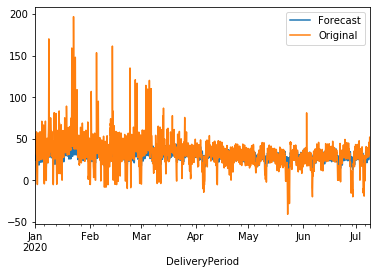

In [809]:
pred1 = train_target_scaler1.inverse_transform(ffn_model1.predict(x=scaled_train_predictors1))
pred_df1 = pd.DataFrame(pred1, columns=["Forecast"], index=train_predictors.index)
pred_df1["Original"] = train_target
pred_df1.plot()
plt.show()

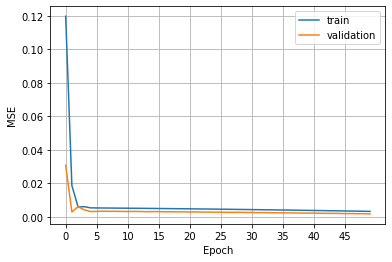

In [796]:
%matplotlib inline
plt.plot(history1.history["mean_squared_error"], label="train")
plt.plot(history1.history["val_mean_squared_error"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0,50,5))
plt.grid()
plt.legend()
plt.show()

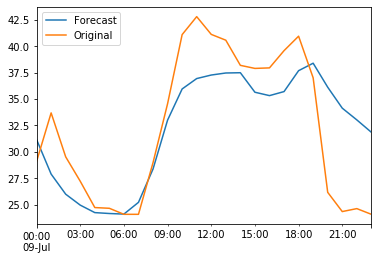

In [797]:
test_pred1 = train_target_scaler1.inverse_transform(ffn_model1.predict(x=train_predictors_scaler1.transform(test_predictors)))
test_pred_df1 = pd.DataFrame(test_pred1, columns=["Forecast"], index=test_predictors.index)
test_pred_df1["Original"] = test_target
test_pred_df1.plot()

In [798]:
print(np.sqrt(metrics.mean_squared_error(test_pred_df1["Original"], test_pred_df1["Forecast"])),
np.sqrt(metrics.mean_absolute_error(test_pred_df1["Original"], test_pred_df1["Forecast"])))

4.613876172635748 1.8919010288853733


### Tanh

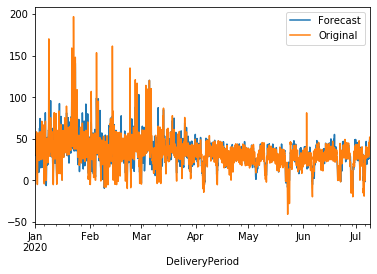

In [799]:
pred2 = train_target_scaler2.inverse_transform(ffn_model2.predict(x=scaled_train_predictors2))
pred_df2 = pd.DataFrame(pred2, columns=["Forecast"], index=train_predictors.index)
pred_df2["Original"] = train_target
pred_df2.plot()

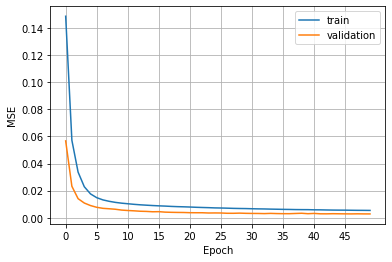

In [800]:
%matplotlib inline
plt.plot(history2.history["mean_squared_error"], label="train")
plt.plot(history2.history["val_mean_squared_error"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0,50,5))
plt.grid()
plt.legend()
plt.show()

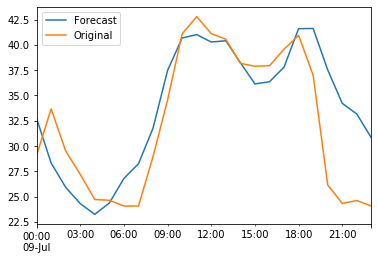

In [801]:
test_pred2 = train_target_scaler2.inverse_transform(ffn_model2.predict(x=train_predictors_scaler2.transform(test_predictors)))
test_pred_df2 = pd.DataFrame(test_pred2, columns=["Forecast"], index=test_predictors.index)
test_pred_df2["Original"] = test_target
test_pred_df2.plot()

In [802]:
print(np.sqrt(metrics.mean_squared_error(test_pred_df2["Original"], test_pred_df2["Forecast"])),
np.sqrt(metrics.mean_absolute_error(test_pred_df2["Original"], test_pred_df2["Forecast"])))

4.503633680929946 1.8259236528466858


### ReLU

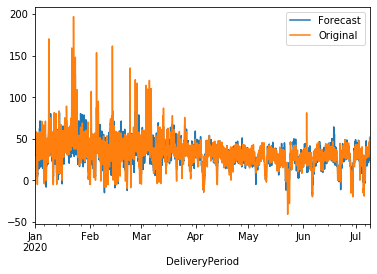

In [803]:
pred3 = train_target_scaler3.inverse_transform(ffn_model3.predict(x=scaled_train_predictors3))
pred_df3 = pd.DataFrame(pred3, columns=["Forecast"], index=train_predictors.index)
pred_df3["Original"] = train_target
pred_df3.plot()

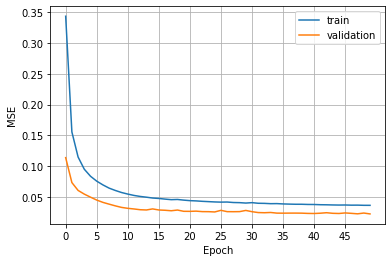

In [804]:
%matplotlib inline
plt.plot(history3.history["mean_squared_error"], label="train")
plt.plot(history3.history["val_mean_squared_error"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0,50,5))
plt.grid()
plt.legend()
plt.show()

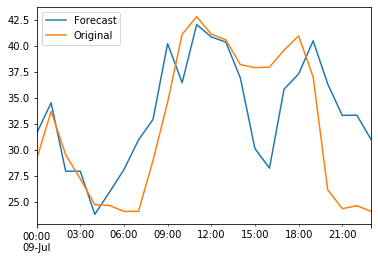

In [805]:
test_pred3 = train_target_scaler3.inverse_transform(ffn_model3.predict(x=train_predictors_scaler3.transform(test_predictors)))
test_pred_df3 = pd.DataFrame(test_pred3, columns=["Forecast"], index=test_predictors.index)
test_pred_df3["Original"] = test_target
test_pred_df3.plot()

In [806]:
print(np.sqrt(metrics.mean_squared_error(test_pred_df3["Original"], test_pred_df3["Forecast"])),
np.sqrt(metrics.mean_absolute_error(test_pred_df3["Original"], test_pred_df3["Forecast"])))

5.193875400848029 2.0257354860620294


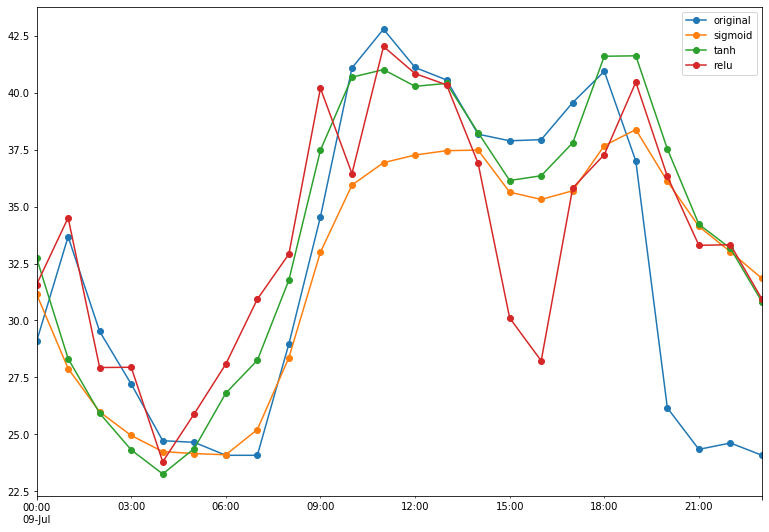

In [807]:
pd.DataFrame(data=dict(original=test_pred_df1["Original"],sigmoid=test_pred_df1["Forecast"], tanh=test_pred_df2["Forecast"], relu=test_pred_df3["Forecast"])).plot(marker='o', figsize=(13,9))
plt.show()

In [808]:
print(f"Sigmoid RMSE: {metrics.mean_squared_error(test_pred_df1['Original'], test_pred_df1['Forecast'], squared=False)}")
print(f"Sigmoid MAE: {metrics.mean_absolute_error(test_pred_df1['Original'], test_pred_df1['Forecast'])}\n")
      
print(f"Tanh RMSE: {metrics.mean_squared_error(test_pred_df2['Original'], test_pred_df2['Forecast'], squared=False)}")
print(f"Tanh MAE: {metrics.mean_absolute_error(test_pred_df2['Original'], test_pred_df2['Forecast'])}\n")
      
print(f"ReLU RMSE: {metrics.mean_squared_error(test_pred_df3['Original'], test_pred_df3['Forecast'], squared=False)}")
print(f"ReLU MAE: {metrics.mean_absolute_error(test_pred_df3['Original'], test_pred_df3['Forecast'])}")

Sigmoid RMSE: 4.613876172635748
Sigmoid MAE: 3.579289503097534

Tanh RMSE: 4.503633680929946
Tanh MAE: 3.333997186024984

ReLU RMSE: 5.193875400848029
ReLU MAE: 4.103604259490967


# Recurrent Neural Networks (RNNs)

In [703]:
def create_2L_rnn(num_of_blocks, n_timesteps, n_features, act_fn, opt="adam", loss="mse", metrics="mean_squared_error"):
    model = Sequential()
#     initializer = initializers.he_uniform(1)
    
    # Add first hidden layer (with input layer specification)
    model.add(LSTM(num_of_blocks, return_sequences=True, activation=act_fn, input_shape=(n_timesteps, n_features)))#, batch_input_shape=(24, n_timesteps, n_features), stateful=True))#, kernel_initializer=initializer))
    
    # Add remaining hidden layers
#     model.add(LSTM(num_of_blocks, return_sequences=True, activation=act_fn))#, kernel_initializer=initializer))
    model.add(LSTM(num_of_blocks, activation=act_fn))#, kernel_initializer=initializer))

    # Add output layer
    model.add(Dense(1))#, kernel_initializer=initializer))

#     optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return(model)

In [473]:
def create_data_window(data, n_steps, step_size=24):
    new_data = data.copy()
    column = data.columns[0]

    # Add lagged values as new columns
    for step in range(n_steps):
        new_data.insert(new_data.shape[1], f"{column}-{step_size*(step+1)}h", new_data[[column]].shift(step_size * (step+1)))
        
    # Remove rows with NAs
    new_data = new_data.loc[new_data.notna().all(axis=1)]
    
    return(new_data)

In [618]:
# Read in datasets
price_path = ["Datasets/DAMPrices.csv", "Datasets/DAMPrices2.csv"]
prices = tools.read_price_data(price_path)

bm_price_paths = ["Datasets/BMInfo1.csv", "Datasets/BMInfo2.csv", "Datasets/BMInfo3.csv"]
bm_prices = tools.read_bm_price_data(bm_price_paths)

wind_path = ["Datasets/WindForecast.csv", "Datasets/WindForecast2.csv"]
wind_forecast = tools.read_forecast_data(wind_path)
wind_forecast.columns = ["Wind"]

demand_path = ["Datasets/DemandForecast.csv", "Datasets/DemandForecast2.csv"]
demand_forecast = tools.read_forecast_data(demand_path)
demand_forecast.columns = ["Demand"]

availabilities_path = ["Datasets/AvailabilityProxy.csv", "Datasets/AvailabilityProxy2.csv"]
availabilities = tools.read_availabilities_data(availabilities_path)

In [696]:
# Combine the datasets
start_dates = list(map(lambda var: var.index[0], [prices, bm_prices, availabilities, wind_forecast, demand_forecast]))
latest_start_date = max(start_dates)
target_end_date = prices.index[-1]


# Match data start dates
prices = prices.loc[prices.index.date >= latest_start_date.date()]
bm_prices = bm_prices.loc[bm_prices.index.date >= latest_start_date.date()]
wind_forecast = wind_forecast.loc[wind_forecast.index.date >= latest_start_date.date()]
demand_forecast = demand_forecast.loc[demand_forecast.index.date >= latest_start_date.date()]


# Check for variables that do not have enough data for forecast date (last day of prices)
for var in [prices,availabilities,wind_forecast,demand_forecast]:
    if var.index[-1] < target_end_date:
        print(f"Must not include {var.columns}")

        
# Match data end dates
prices = prices.loc[prices.index.date <= prices.index.date[-1]]
bm_prices = bm_prices.loc[bm_prices.index.date <= prices.index.date[-1]]
wind_forecast = wind_forecast.loc[wind_forecast.index.date <= prices.index.date[-1]]
demand_forecast = demand_forecast.loc[demand_forecast.index.date <= prices.index.date[-1]]
        
    
# Reformat data for input into RNNs
time_steps = 7
rnn_prices = create_data_window(prices, time_steps)
rnn_target = rnn_prices[[rnn_prices.columns[0]]]
rnn_prices.drop(rnn_prices.columns[0], axis=1, inplace=True)

rnn_bm_prices = create_data_window(bm_prices, time_steps)
rnn_bm_prices.drop(rnn_bm_prices.columns[0], axis=1, inplace=True)

rnn_wind_forecast = create_data_window(wind_forecast, time_steps)
rnn_wind_forecast.drop(rnn_wind_forecast.columns[-1], axis=1, inplace=True)

rnn_demand_forecast = create_data_window(demand_forecast, time_steps)
rnn_demand_forecast.drop(rnn_demand_forecast.columns[-1], axis=1, inplace=True)


# Split into training and test set
last_day_of_data = dt.datetime.combine(prices.index.date[-1], dt.datetime.min.time())
test_data_index = pd.date_range(start=last_day_of_data, end=last_day_of_data+dt.timedelta(hours=23), freq='h')


# Test data
rnn_test_prices = rnn_prices.loc[test_data_index]
rnn_test_bm_prices = rnn_bm_prices.loc[test_data_index]
rnn_test_wind_forecast = rnn_wind_forecast.loc[test_data_index]
rnn_test_demand_forecast = rnn_demand_forecast.loc[test_data_index]
rnn_test_target = rnn_target.loc[test_data_index]


# Train data
rnn_train_prices = rnn_prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
rnn_train_bm_prices = rnn_bm_prices.loc[:last_day_of_data-dt.timedelta(hours=1)]
rnn_train_wind_forecast = rnn_wind_forecast.loc[:last_day_of_data-dt.timedelta(hours=1)]
rnn_train_demand_forecast = rnn_demand_forecast.loc[:last_day_of_data-dt.timedelta(hours=1)]
rnn_train_target = rnn_target.loc[:last_day_of_data-dt.timedelta(hours=1)]

###########################################################################################################################
cutoff = dt.datetime(2020,1,1)
rnn_train_prices = rnn_train_prices.loc[rnn_train_prices.index >= cutoff]
rnn_train_bm_prices = rnn_train_bm_prices.loc[rnn_train_bm_prices.index >= cutoff]
rnn_train_wind_forecast = rnn_train_wind_forecast.loc[rnn_train_wind_forecast.index >= cutoff]
rnn_train_demand_forecast = rnn_train_demand_forecast.loc[rnn_train_demand_forecast.index >= cutoff]
rnn_train_target = rnn_train_target.loc[rnn_train_target.index >= cutoff]
###########################################################################################################################

# Combine train and test features into one tensor each
rnn_test_predictors = np.hstack((rnn_test_prices, rnn_test_bm_prices, rnn_test_wind_forecast, rnn_test_demand_forecast)).reshape(rnn_test_prices.shape[0], 4, time_steps).transpose(0,2,1)
rnn_train_predictors = np.hstack((rnn_train_prices, rnn_train_bm_prices, rnn_train_wind_forecast, rnn_train_demand_forecast)).reshape(rnn_train_prices.shape[0], 4, time_steps).transpose(0,2,1)

Must not include Index(['WIND', 'MULTI_FUEL', 'GAS', 'HYDRO', 'PEAT', 'COAL', 'PUMP_STORAGE',
       'BIOMASS', 'OIL', 'DISTILLATE', 'SOLAR', 'NONE'],
      dtype='object')


In [697]:
test_lists = [rnn_test_prices, rnn_test_bm_prices, rnn_test_wind_forecast, rnn_test_demand_forecast, rnn_test_target]
train_lists = [rnn_train_prices, rnn_train_bm_prices, rnn_train_wind_forecast, rnn_train_demand_forecast, rnn_train_target]

list(map(lambda x: x.index[[0,-1]], test_lists))

[DatetimeIndex(['2020-07-09 00:00:00', '2020-07-09 23:00:00'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2020-07-09 00:00:00', '2020-07-09 23:00:00'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2020-07-09 00:00:00', '2020-07-09 23:00:00'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2020-07-09 00:00:00', '2020-07-09 23:00:00'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2020-07-09 00:00:00', '2020-07-09 23:00:00'], dtype='datetime64[ns]', freq=None)]

In [698]:
list(map(lambda x: x.index[[0,-1]], train_lists))

[DatetimeIndex(['2020-01-01 00:00:00', '2020-07-08 23:00:00'], dtype='datetime64[ns]', name='DeliveryPeriod', freq=None),
 DatetimeIndex(['2020-01-01 00:00:00', '2020-07-08 23:00:00'], dtype='datetime64[ns]', name='DeliveryPeriod', freq=None),
 DatetimeIndex(['2020-01-01 00:00:00', '2020-07-08 23:00:00'], dtype='datetime64[ns]', name='DeliveryPeriod', freq=None),
 DatetimeIndex(['2020-01-01 00:00:00', '2020-07-08 23:00:00'], dtype='datetime64[ns]', name='DeliveryPeriod', freq=None),
 DatetimeIndex(['2020-01-01 00:00:00', '2020-07-08 23:00:00'], dtype='datetime64[ns]', name='DeliveryPeriod', freq=None)]

We need to define a new scaler function for the RNN inputs

In [725]:
def get_rnn_scaler(predictors, activation, copy_df=True):
    activation_ranges = {
        "tanh": (-1,1),
        "sigmoid": (0,1),
        "relu": (0,5)
    }
    real_predictors = predictors[:,0,:].copy()
    
    # Create and fit scaler
    scaler = prep.MinMaxScaler(feature_range=activation_ranges[activation], copy=copy_df)
    scaler.fit(real_predictors)
    
    return(scaler)

In [726]:
def transform_rnn_scale(predictors, scaler):
    # Transform predictors
    scaled_predictors = predictors.copy()
    
    for time_step in range(scaled_predictors.shape[1]):
        scaled_predictors[:,time_step,:] = scaler.transform(scaled_predictors[:,time_step,:])
        
    return(scaled_predictors)

In [727]:
def invert_rnn_scale(scaled_predictors, scaler):
    original_predictors = scaled_predictors.copy()
    
    for time_step in range(original_predictors.shape[1]):
        original_predictors[:,time_step,:] = scaler.inverse_transform(scaled_predictors[:,time_step,:])
        
    return(original_predictors)

## Fit different activation functions

### Sigmoid

In [750]:
act = "sigmoid"

rnn_train_predictors_scaler1 = get_rnn_scaler(rnn_train_predictors, activation=act)
rnn_scaled_train_predictors1 = transform_rnn_scale(rnn_train_predictors, rnn_train_predictors_scaler1)
rnn_train_target_scaler1, rnn_scaled_train_target1 = scale_predictors(rnn_train_target, activation=act)

rnn_model1 = create_2L_rnn(num_of_blocks=10, n_timesteps=rnn_train_predictors.shape[1], n_features=rnn_train_predictors.shape[2], act_fn=act)
history1 = rnn_model1.fit(x=rnn_scaled_train_predictors1, y=rnn_scaled_train_target1, epochs=50, validation_split=0.2)

Epoch 1/50
114/114 [==============================] - 1s 11ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/50
114/114 [==============================] - 1s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 3/50
114/114 [==============================] - 1s 7ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/50
114/114 [==============================] - 1s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/50
114/114 [==============================] - 1s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/50
114/114 [==============================] - 1s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 7/50
114/114 [=======

### Tanh

In [753]:
act = "tanh"

rnn_train_predictors_scaler2 = get_rnn_scaler(rnn_train_predictors, activation=act)
rnn_scaled_train_predictors2 = transform_rnn_scale(rnn_train_predictors, rnn_train_predictors_scaler2)
rnn_train_target_scaler2, rnn_scaled_train_target2 = scale_predictors(rnn_train_target, activation=act)

rnn_model2 = create_2L_rnn(num_of_blocks=20, n_timesteps=rnn_train_predictors.shape[1], n_features=rnn_train_predictors.shape[2], act_fn=act)
history2 = rnn_model2.fit(x=rnn_scaled_train_predictors2, y=rnn_scaled_train_target2, epochs=50, validation_split=0.2)

Epoch 1/50
114/114 [==============================] - 2s 17ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 2/50
114/114 [==============================] - 1s 8ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 3/50
114/114 [==============================] - 3s 24ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/50
114/114 [==============================] - 1s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/50
114/114 [==============================] - 1s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/50
114/114 [==============================] - 1s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 7/50
114/114 [======

### ReLU

In [754]:
act = "relu"

rnn_train_predictors_scaler3 = get_rnn_scaler(rnn_train_predictors, activation=act)
rnn_scaled_train_predictors3 = transform_rnn_scale(rnn_train_predictors, rnn_train_predictors_scaler3)
rnn_train_target_scaler3, rnn_scaled_train_target3 = scale_predictors(rnn_train_target, activation=act)

rnn_model3 = create_2L_rnn(num_of_blocks=30, n_timesteps=rnn_train_predictors.shape[1], n_features=rnn_train_predictors.shape[2], act_fn=act)
history3 = rnn_model3.fit(x=rnn_scaled_train_predictors3, y=rnn_scaled_train_target3, epochs=50, validation_split=0.2)

Epoch 1/50
114/114 [==============================] - 2s 15ms/step - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.0700 - val_mean_squared_error: 0.0700
Epoch 2/50
114/114 [==============================] - 1s 8ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 3/50
114/114 [==============================] - 1s 11ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 4/50
114/114 [==============================] - 1s 8ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 5/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 6/50
114/114 [==============================] - 1s 8ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 7/50
114/114 [=====

## Generate forecasts and plot results

### Sigmoid

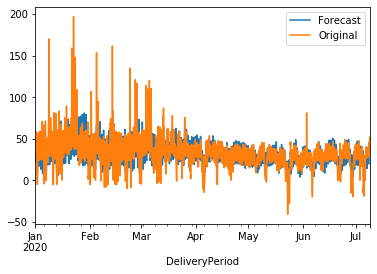

In [813]:
%matplotlib inline
pred1 = rnn_train_target_scaler1.inverse_transform(rnn_model1.predict(x=rnn_scaled_train_predictors1))
pred_df1 = pd.DataFrame(pred1, columns=["Forecast"], index=rnn_train_target.index)
pred_df1["Original"] = train_target
pred_df1.plot()
plt.show()

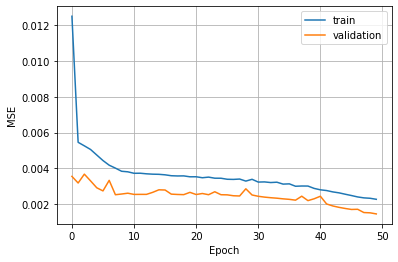

In [755]:
%matplotlib inline
plt.plot(history1.history["mean_squared_error"], label="train")
plt.plot(history1.history["val_mean_squared_error"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0,51,10))
plt.grid()
plt.legend()
plt.show()

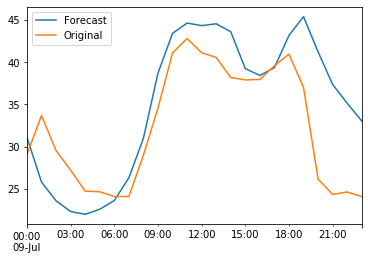

In [756]:
rnn_scaled_test_predictors1 = transform_rnn_scale(rnn_test_predictors, rnn_train_predictors_scaler1)
test_pred1 = rnn_train_target_scaler1.inverse_transform(rnn_model1.predict(x=rnn_scaled_test_predictors1))
test_pred_df1 = pd.DataFrame(test_pred1, columns=["Forecast"], index=rnn_test_target.index)
test_pred_df1["Original"] = rnn_test_target
test_pred_df1.plot()

In [757]:
print(np.sqrt(metrics.mean_squared_error(test_pred_df1["Original"], test_pred_df1["Forecast"])),
np.sqrt(metrics.mean_absolute_error(test_pred_df1["Original"], test_pred_df1["Forecast"])))

6.094657368566478 2.153374092889438


### Tanh

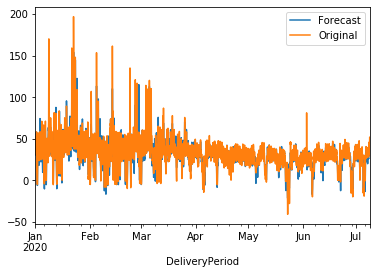

In [814]:
%matplotlib inline
pred2 = rnn_train_target_scaler2.inverse_transform(rnn_model2.predict(x=rnn_scaled_train_predictors2))
pred_df2 = pd.DataFrame(pred2, columns=["Forecast"], index=rnn_train_target.index)
pred_df2["Original"] = train_target
pred_df2.plot()
plt.show()

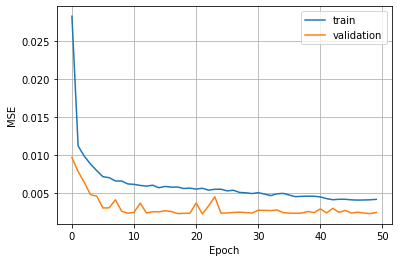

In [758]:
%matplotlib inline
plt.plot(history2.history["mean_squared_error"], label="train")
plt.plot(history2.history["val_mean_squared_error"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0,51,10))
plt.grid()
plt.legend()
plt.show()

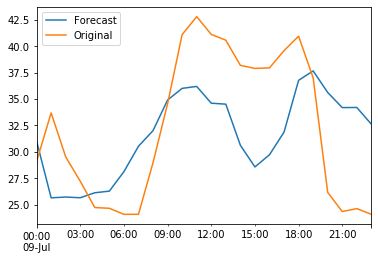

In [759]:
rnn_scaled_test_predictors2 = transform_rnn_scale(rnn_test_predictors, rnn_train_predictors_scaler2)
test_pred2 = rnn_train_target_scaler2.inverse_transform(rnn_model2.predict(x=rnn_scaled_test_predictors2))
test_pred_df2 = pd.DataFrame(test_pred2, columns=["Forecast"], index=rnn_test_target.index)
test_pred_df2["Original"] = rnn_test_target
test_pred_df2.plot()

In [760]:
print(np.sqrt(metrics.mean_squared_error(test_pred_df2["Original"], test_pred_df2["Forecast"])),
np.sqrt(metrics.mean_absolute_error(test_pred_df2["Original"], test_pred_df2["Forecast"])))

6.275952535158957 2.3411486825441217


### ReLU

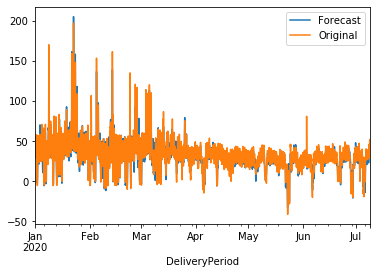

In [815]:
%matplotlib inline
pred3 = rnn_train_target_scaler3.inverse_transform(rnn_model3.predict(x=rnn_scaled_train_predictors3))
pred_df3 = pd.DataFrame(pred3, columns=["Forecast"], index=rnn_train_target.index)
pred_df3["Original"] = train_target
pred_df3.plot()
plt.show()

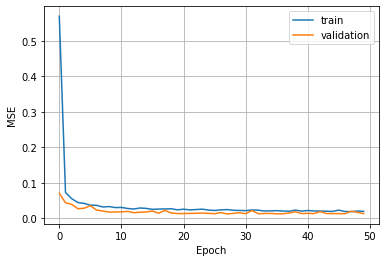

In [762]:
%matplotlib inline
plt.plot(history3.history["mean_squared_error"], label="train")
plt.plot(history3.history["val_mean_squared_error"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xticks(np.arange(0,51,10))
plt.grid()
plt.legend()
plt.show()

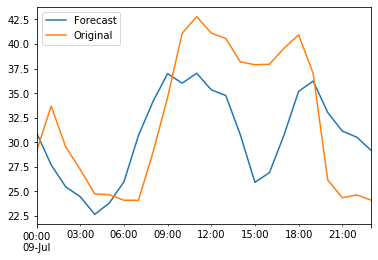

In [763]:
rnn_scaled_test_predictors3 = transform_rnn_scale(rnn_test_predictors, rnn_train_predictors_scaler3)
test_pred3 = rnn_train_target_scaler3.inverse_transform(rnn_model3.predict(x=rnn_scaled_test_predictors3))
test_pred_df3 = pd.DataFrame(test_pred3, columns=["Forecast"], index=rnn_test_target.index)
test_pred_df3["Original"] = rnn_test_target
test_pred_df3.plot()

In [764]:
print(np.sqrt(metrics.mean_squared_error(test_pred_df3["Original"], test_pred_df3["Forecast"])),
np.sqrt(metrics.mean_absolute_error(test_pred_df3["Original"], test_pred_df3["Forecast"])))

5.989578884365104 2.2965972511014385


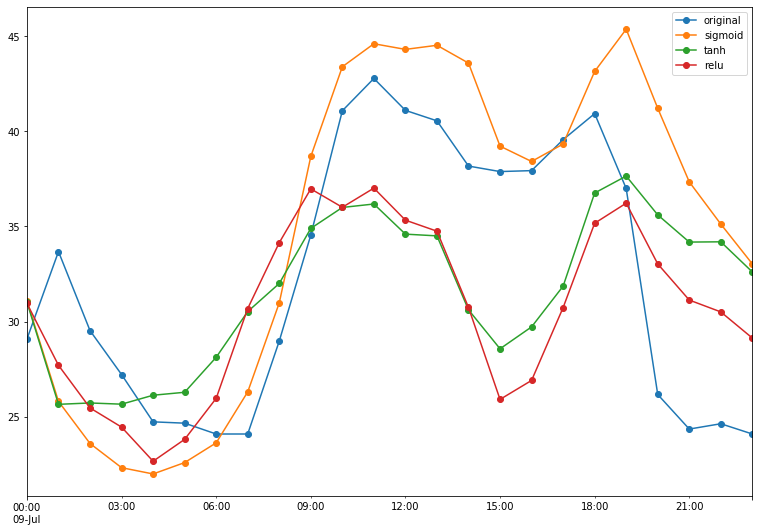

In [771]:
pd.DataFrame(data=dict(original=test_pred_df1["Original"],sigmoid=test_pred_df1["Forecast"], tanh=test_pred_df2["Forecast"], relu=test_pred_df3["Forecast"])).plot(marker='o', figsize=(13,9))
plt.show()

In [777]:
print(f"Sigmoid RMSE: {metrics.mean_squared_error(test_pred_df1['Original'], test_pred_df1['Forecast'], squared=False)}")
print(f"Sigmoid MAE: {metrics.mean_absolute_error(test_pred_df1['Original'], test_pred_df1['Forecast'])}\n")
      
print(f"Tanh RMSE: {metrics.mean_squared_error(test_pred_df2['Original'], test_pred_df2['Forecast'], squared=False)}")
print(f"Tanh MAE: {metrics.mean_absolute_error(test_pred_df2['Original'], test_pred_df2['Forecast'])}\n")
      
print(f"ReLU RMSE: {metrics.mean_squared_error(test_pred_df3['Original'], test_pred_df3['Forecast'], squared=False)}")
print(f"ReLU MAE: {metrics.mean_absolute_error(test_pred_df3['Original'], test_pred_df3['Forecast'])}")

Sigmoid RMSE: 6.094657368566478
Sigmoid MAE: 4.637019983927408

Tanh RMSE: 6.275952535158957
Tanh MAE: 5.480977153778078

ReLU RMSE: 5.989578884365104
ReLU MAE: 5.274358933766683
